# **Facebook Friend Recommendation Using Graph Mining**



**Overviewing Given Data**

Taken data from facebook's recruting challenge on kaggle https://www.kaggle.com/c/FacebookRecruiting data which contains two columns source node and destination nodes in a graph.

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import datetime
import time
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os
import xgboost as xgb
import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf

import gc
from tqdm import tqdm
from scipy.sparse.linalg import svds, eigs
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.metrics import f1_score

In [ ]:
df = pd.read_csv('train1.csv')
df.shape

(99999, 2)

In [ ]:
# Reading the graph
if not os.path.isfile('train_woheader.csv'):
  traincsv = pd.read_csv('train1.csv',nrows=9437519)
  print(traincsv[traincsv.isna().any(1)])
  print(traincsv.info())
  print("Number of duplicate entries: ",sum(traincsv.duplicated()))
  pd.read_csv('train1.csv',nrows=99999).to_csv('train_woheader.csv',header=False,index=False)
  print("Saved the graph into file")
  g=nx.read_edgelist('train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
  print(nx.info(g))

Empty DataFrame
Columns: [source_node, destination_node]
Index: []
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   source_node       99999 non-null  int64
 1   destination_node  99999 non-null  int64
dtypes: int64(2)
memory usage: 1.5 MB
None
Number of duplicate entries:  0
Saved the graph into file
DiGraph with 105844 nodes and 99999 edges


DiGraph with 250 nodes and 200 edges


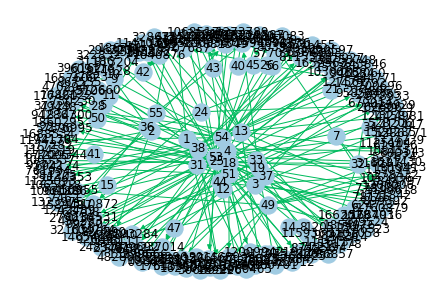

In [ ]:
if not os.path.isfile('train_woheader_sample.csv'):
  pd.read_csv('train1.csv', nrows=200).to_csv('train_woheader_sample.csv' ,header=False,index=False)

  subgraph=nx.read_edgelist('train_woheader_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)

  pos=nx.spring_layout(subgraph)
  nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
  plt.savefig("graph_sample.pdf")
  print(nx.info(subgraph))

# **Explanatory Data Analysis**

In [ ]:
# No of unique persons
print("The number of unique persons",len(g.nodes()))

The number of unique persons 105844


# **No of followers for each person**

In [ ]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No of Followers')
plt.show()

In [ ]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No of Followers')
plt.show()

In [ ]:
plt.boxplot(indegree_dist)
plt.ylabel('No of Followers')
plt.show()

In [ ]:
### 90-100 percentile 
for i in range(0,11):
  print(90+i,'percentile value is',np.percentile(indegree_dist,90+i))

In [ ]:
### 99-100 percentile 
for i in range(10,110,10):
  print(99+(i/100),'percentile value is',np.percentile(indegree_dist,99+(i/100)))

In [ ]:
%matplotlib inline
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(indegree_dist, color='#16A085')
plt.xlabel('PDF of Indegree')
sns.despine()
#plt.show()

# **No of people each person is following**

In [ ]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No of people each person is following')
plt.show()

In [ ]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No of people each person is following')
plt.show()

In [ ]:
plt.boxplot(indegree_dist)
plt.ylabel('No of people each person is following')
plt.show()

In [ ]:
### 90-100 percentile
for i in range(0,11):
  print(90+i,'percentile value is',np.percentile(outdegree_dist,90+i))

In [ ]:
### 99-100 percentile
for i in range(10,110,10):
  print(99+(i/100),'percentile value is',np.percentile(outdegree_dist,99+(i/100)))

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(outdegree_dist, color='#16A085')
plt.xlabel('PDF Of OutDegree')
sns.despine()

In [ ]:
print('No of persons those are not following anyone are' ,sum(np.array(outdegree_dist)==0),'and % is',sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist))

In [ ]:
print('No of persons having zero followers are' ,sum(np.array(indegree_dist)==0),'and % is',sum(np.array(indegree_dist)==0)*100/len(indegree_dist))

In [ ]:
count=0
for i in g.nodes():
  if len(list(g.predecessors(i)))==0:
    if len(list(g.successors(i)))==0:
      count+=1
print('No of persons those are not following anyone and also not having any followers are',count)

# **Both Followers+Following**

In [ ]:
from collections import Counter
dict_in = dict(g.in_degree())
dict_out = dict(g.out_degree())
d = Counter(dict_in) + Counter(dict_out)
in_out_degree = np.array(list(d.values()))

In [ ]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No of people each person is following + followers')
plt.show()

In [ ]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No of people each person is following + followers')
plt.show()

In [ ]:
### 90-100 percentile
for i in range(0,11):
  print(90+i,'percentile value is',np.percentile(in_out_degree_sort,90+i))

In [ ]:
### 99-100 percentile
for i in range(10,110,10):
  print(99+(i/100),'percentile value is',np.percentile(in_out_degree_sort,99+(i/100)))

In [ ]:
print('Minimum of no of followers + following is',in_out_degree.min())
print(np.sum(in_out_degree==in_out_degree.min()),' persons having minimum no of followers + following')

Minimum of no of followers + following is 1
86846  persons having minimum no of followers + following


In [ ]:
print('Max of no of followers + following is',in_out_degree.max())
print(np.sum(in_out_degree==in_out_degree.max()),'persons having maximum no of followers + following')

Max of no of followers + following is 895
1 persons having maximum no of followers + following


In [ ]:
print('No of persons having followers + following less than 10 are',np.sum(in_out_degree<10))

No of persons having followers + following less than 10 are 102944


In [ ]:
print('No of weakly connected components',len(list(nx.weakly_connected_components(g))))
count=0
for i in list(nx.weakly_connected_components(g)):
  if len(i)==2:
    count+=1
print('weakly connected components with 2 nodes',count)

No of weakly connected components 12030
weakly connected components with 2 nodes 4526


# **Posing problem into classification problem**

# **Generating some edges which are not present in graph for supervised learning**

Generating bad links from graph which are not in graph and whose shortest path is greater than 2.

In [ ]:

### generating bad edges from given graph
import random
if not os.path.isfile('missing_edges_final.p'):
  # getting all set of edges
  r = csv.reader(open('train_woheader.csv','r'))
  edges=dict()
  for edge in r:
    edges[(edge[0], edge[1])] = 1
  
  missing_edges = set([])
  while((len(missing_edges))<99999):
    a=random.randint(1, 105844)
    b=random.randint(1, 105844)
    tmp = edges.get((a,b),-1)
    if tmp == -1 and a!=b:
      try:
        if nx.shortest_path_length(g,source=a,target=b) > 2:
          missing_edges.add((a,b))
        else:
          continue
      except:
        missing_edges.add((a,b))
    else:
      continue
  pickle.dump(missing_edges,open('missing_edges_final.p','wb'))
else:
  missing_edges = pickle.load(open('missing_edges_final.p','rb'))



In [ ]:
missing_edges = pickle.load(open('missing_edges_final.p','rb'))
len(missing_edges)

# **Training and Test data split**

Removed edges from graph and used as test data and after removing used that graph for creating features for Train and Test data.

In [ ]:
from sklearn.model_selection import train_test_split
if (not os.path.isfile('train_pos_after_eda.csv')) and (not os.path.isfile('test_pos_after_eda.csv')):
  # reading total data as dataframe
  df_pos = pd.read_csv('train1.csv')
  df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])

  print('Number of nodes in the graph with edges', df_pos.shape[0])
  print('Number of nodes in the graph without edges', df_neg.shape[0])

  # Training and Testing data split
  # Splitted data into 80-20
  # positive links and negative links separately because we need positive training data only for creating graph
  # and also for feature generation
  X_train_pos,X_test_pos,y_train_pos,y_test_pos = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.1,random_state=9)
  X_train_neg,X_test_neg,y_train_neg,y_test_neg = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.1,random_state=9)

  print('='*60)
  print('Number of nodes in the train data graph with edges',X_train_pos.shape[0],'=',y_train_pos.shape[0])
  print('Number of nodes in the train data graph without edges',X_train_neg.shape[0],'=',y_train_neg.shape[0])
  print('='*60)
  print('Number of nodes in the test data graph with edges',X_test_pos.shape[0],'=',y_test_pos.shape[0])
  print('Number of nodes in the test data graph without edges',X_test_neg.shape[0],'=',y_test_neg.shape[0])

  # removing header and saving
  X_train_pos.to_csv('train_pos_after_eda.csv',header=False,index=False)
  X_test_pos.to_csv('test_pos_after_eda.csv',header=False,index=False)
  X_train_neg.to_csv('train_neg_after_eda.csv',header=False,index=False)
  X_test_neg.to_csv('test_neg_after_eda.csv',header=False,index=False)
else:
  # Graph from Training data only
  print('deleting.......')
  del missing_edges

In [ ]:
if(os.path.isfile('train_pos_after_eda.csv')) and (os.path.isfile('test_pos_after_eda.csv')):
  train_graph = nx.read_edgelist('train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
  test_graph = nx.read_edgelist('test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
  print(nx.info(train_graph))
  print(nx.info(test_graph))

  # finding the unique nodes in the both train and test graphs
  train_nodes_pos = set(train_graph.nodes())
  test_nodes_pos =  set(test_graph.nodes())

  trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
  trY_teN = len(train_nodes_pos - test_nodes_pos)
  teY_trN = len(test_nodes_pos - train_nodes_pos)

  print('no of people common in train and test -- ',trY_teY)
  print('no of people present in train but not present in test -- ',trY_teN)

  print('no of people present in test but not present in train -- ',teY_trN)
  print(' % of people not there in train but exist in Test in total Test data are {} %'.format(teY_trN/len(test_nodes_pos)*100))

In [ ]:
# final train and test data sets
if (not os.path.isfile('train_after_eda.csv')) and \
(not os.path.isfile('test_after_eda.csv')) and \
(not os.path.isfile('train_y.csv')) and \
(not os.path.isfile('test_y.csv')) and \
(os.path.isfile('train_pos_after_eda.csv')) and \
(os.path.isfile('test_pos_after_eda,csv')) and \
(os.path.isfile('train_neg_after_eda.csv')) and \
(os.path,isfile('test_neg_after_eda.csv')):

  X_train_pos = pd.read_csv('train_pos_after_eda.csv',names=['source_node','destination_node'])
  X_test_pos = pd.read_csv('test_pos_after_eda.csv',names=['source_node','destination_node'])
  X_train_neg = pd.read_csv('train_neg_after_eda.csv',names=['source_node','destination_node'])
  X_test_neg = pd.read_csv('test_neg_after_eda.csv',names=['source_node','destination_node'])

  print('='*60)
  print('Number of nodes in the train data graph with edges',X_train_pos.shape[0])
  print('Number of nodes in the train data graph without edges',X_train_neg.shape[0])
  print('='*60)
  print('Number of nodes in the test data graph with edges',X_test_pos.shape[0])
  print('Number of nodes in the test data graph without edges',X_test_neg.shape[0])

X_train = X_train_pos.append(X_train_neg,ignore_index=True)
y_train = np.concatenate((y_train_pos,y_train_neg))
X_test = X_test_pos.append(X_test_neg,ignore_index=True)
y_test = np.concatenate((y_test_pos,y_test_neg))

X_train.to_csv('train_after_eda.csv',header=False,index=False)
X_test.to_csv('test_after_eda.csv',header=False,index=False)
pd.DataFrame(y_train.astype(int)).to_csv('train_y.csv',header=False,index=False)
pd.DataFrame(y_test.astype(int)).to_csv('test_y.csv',header=False,index=False)

In [ ]:
print("Data points in train data",X_train.shape)
print("Data points in test data",X_test.shape)
print("Shape of target variable in train",y_train.shape)
print("Shape of target variable in test",y_test.shape)

In [ ]:
# Importing libraries
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd # pandas to create small dataframes
import datetime # Convert to unix time
import time # Convert to unix time
import numpy as np # Do arithmetic operations on arrays
# matplotlib used for plots
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns # Plots
from matplotlib import rcParams # Size of plots
from sklearn.cluster import MiniBatchKMeans, KMeans # Clustering
import math
import pickle
import os
import xgboost as xgb
import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds,eigs
import gc
from tqdm import tqdm

# **Reading The Data**

In [ ]:
train_graph = nx.read_edgelist('train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(train_graph))

DiGraph with 97098 nodes and 89999 edges


# **Similarity Measures**

# **Jaccard Distance**

https://www.statisticshowto.com/jaccard-index/

image.png

In [ ]:
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

In [ ]:
# one test case
print(jaccard_for_followees(1273129,123420))

0


In [ ]:
# node 734370 not in graph
print(jaccard_for_followees(1273129,734370))

In [ ]:
#for followers
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [ ]:
print(jaccard_for_followers(1273129,1452178))

In [ ]:
# node 734370 not in graph
print(jaccard_for_followers(1643784,734370))

# **Cosine Distance**

image.png

In [ ]:
#for followees
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [ ]:
print(cosine_for_followees(1273129,123420))

In [ ]:
print(cosine_for_followees(1273129,734370))

In [ ]:
def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [ ]:
print(cosine_for_followers(5,1646876))

In [ ]:
print(cosine_for_followers(1643784,734370))

# **Ranking Measures**

https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html

PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links.

Mathematical PageRanks for a simple network, expressed as percentages. (Google uses a logarithmic scale.) Page C has a higher PageRank than Page E, even though there are fewer links to C; the one link to C comes from an important page and hence is of high value. If web surfers who start on a random page have an 85% likelihood of choosing a random link from the page they are currently visiting, and a 15% likelihood of jumping to a page chosen at random from the entire web, they will reach Page E 8.1% of the time. (The 15% likelihood of jumping to an arbitrary page corresponds to a damping factor of 85%.) Without damping, all web surfers would eventually end up on Pages A, B, or C, and all other pages would have PageRank zero. In the presence of damping, Page A effectively links to all pages in the web, even though it has no outgoing links of its own.

# **Page Ranking**

https://en.wikipedia.org/wiki/PageRank

In [ ]:
if not os.path.isfile('page_rank.p'):
  pr = nx.pagerank(train_graph,alpha=0.85)
  pickle.dump(pr,open('page_rank.p','wb'))
else:
  pr = pickle.load(open('page_rank.p','rb'))

In [ ]:
print('min',pr[min(pr,key=pr.get)])
print('max',pr[max(pr,key=pr.get)])
print('mean',float(sum(pr.values()))/len(pr))

min 9.050403740657122e-06
max 2.662571976417526e-05
mean 1.0298873303269203e-05


In [ ]:
# for imputing to nodes which are not there in train data
mean_pr = float(sum(pr.values()))/len(pr)
print(mean_pr)

1.0298873303269203e-05


# **Graph Features**

# **Shortest path**

Getting Shortest path between two nodes,if nodes have direct path i.e directly connected then we are removing that edge and calculating path.

In [ ]:
# if nodes has direct edge then deleting that edge and calculating shortest path
def compute_shortest_path_length(a,b):
  p=-1
  try:
    if train_graph.has_edge(a,b):
      train_graph.remove_edge(a,b)
      p=nx.shortest_path_length(train_graph,source=a,target=b)
      train_graph.add_edge(a,b)
    else:
      p=nx.shortest_path_length(train_graph,source=a,target=b)
    return p
  except:
    return -1

In [ ]:
# testing
compute_shortest_path_length(876,198460)

-1

In [ ]:
# testing
compute_shortest_path_length(1643784,734370)

-1

# **Checking from same community**

In [ ]:
# getting weekly connected edges from graph
wcc=list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
  index = []
  if train_graph.has_edge(b,a):
    return 1
  if train_graph.has_edge(a,b):
    for i in wcc:
      if a in i:
        index=i
        break
    if (b in index):
      train_graph.remove_edge(a,b)
      if compute_shortest_path_length(a,b)==-1:
        train_graph.add_edge(a,b)
        return 0
      else:
        train_graph.add_edge(a,b)
        return 1
    else:
      return 0
  else:
    for i in wcc:
      if a in i:
        index=i
        break
    if (b in index):
      return 1
    else:
      return 0

In [ ]:
belongs_to_same_wcc(867,1705058)

0

In [ ]:
belongs_to_same_wcc(1643784,734370)

# **Adamic/Adar Index**

Adamic/Adar measures is defined as inverted sum of degrees of common neighbours for given two vertices.

image.png

In [ ]:
# adar index
def calc_adar_in(a,b):
  sum=0
  try:
    n=list(set(train_graph.successors(a)),intersection(set(train_graph.successors(b))))
    if len(n)!=0:
      for i in n:
        sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
      return sum
    else:
      return 0
  except:
    return 0

In [ ]:
calc_adar_in(1,189226)

0

In [ ]:
calc_adar_in(1643784,734370)

0

# **Is person was following back**

In [ ]:
def follows_back(a,b):
  if train_graph.has_edge(b,a):
    return 1
  else:
    return 0

In [ ]:
follows_back(1,189226)

In [ ]:
follows_back(1643784,734370)

# **Katz Centrality**

https://en.wikipedia.org/wiki/Katz_centrality

https://www.geeksforgeeks.org/katz-centrality-centrality-measure/

Katz centrality computes the centrality for a node based on the centrality of its neighbours.It is a generalization of the eienvector centrality.The Katz Centrality for a node i is 

image.png

where A is the adjancency matrix of the graph G with eigenvalues

image.png

image.png

image.png

The parameter controls the initial centrality

In [ ]:
if not os.path.isfile('katz.p'):
  katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
  pickle.dump(katz,open('katz.p','wb'))
else:
  katz = pickle.load(open('katz.p','rb')  )

In [ ]:
print('min',katz[min(katz,key=katz.get)])
print('max',katz[max(katz,key=katz.get)])
print('mean',float(sum(katz.values()))/len(katz))

min 0.003194355412214965
max 0.003356095609096072
mean 0.0032091741778020847


In [ ]:
mean_katz = float(sum(katz.values()))/len(katz)
print(mean_katz)

0.0032091741778020847


# **HITS Score**

The HITS algorithm computes two numbers for a node. Authorities estimates the node value based on the incoming links. Hubs estimates the node value based on outgoing links

https://en.wikipedia.org/wiki/HITS_algorithm

In [ ]:
if not os.path.isfile('hits.p'):
    hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
    pickle.dump(hits,open('hits.p','wb'))
else:
    hits = pickle.load(open('hits.p','rb'))

In [ ]:
print('min',hits[0][min(hits[0],key=hits[0].get)])
print('max',hits[0][max(hits[0],key=hits[0].get)])
print('mean',float(sum(hits[0].values()))/len(hits[0]))

min -2.796610137249541e-15
max 0.7771774231450991
mean 1.029887330326064e-05


# **Featurization**

In [ ]:
import random
if os.path.isfile('train_after_eda.csv'):
  filename = "train_after_eda.csv"
  #Uncommenting this line if we dont know the length of the file name
  # Here we have hardcoded the number of lines as 15100030
  # n_train =  sum(1 for line in open(filename)) # number of records in file (excludes header)
  n_train = 15100028
  s = 100000 #desired sample size
  skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))  
  # https://www.stackoverflow.com/a/22259008/4084039

In [ ]:
if os.path.isfile('train_after_eda.csv'):
  filename="test_after_eda.csv"
  # Uncommenting this line if we dont know the length of the filename
  # We have hardcoded the number of lines as 3775008
  # n_test = sum(1 for line in open(filename)) # number of records in file (excludes header)
  n_test = 3775006
  s = 50000 # desired sample size
  skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))
  # https://www.stackoverflow.com/a/22259008/4084039

In [ ]:
print('Number of rows in the train data file:',n_train)
print('Number of rows we are going to eliminate in train data are',len(skip_train))
print('Number of rows in the test data file:',n_test)
print('Number of rows we are going to eliminate in test data are',len(skip_test))

In [ ]:
df_final_train = pd.read_csv('train_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('train_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(2)

In [ ]:
df_final_test = pd.read_csv('test_after_eda.csv',skiprows=skip_test,names=['source_node','destination_node'])
df_final_test['indicator_link'] = pd.read_csv('test_y.csv',skiprows=skip_test,names=['indicator_link'])
print("Our test matrix size",df_final_test.shape)
df_final_test.head(2)

# **Adding set of features**

**we will create those each of these features for both train and test data points**

1.jaccard_followers
2.jaccard_followees
3.cosine_followers
4.cosine_followees
5.num_followers_s
6.num_followees_s
7.num_followers_d
8.num_followees_d
9.inter_followers
10.inter_followees

In [ ]:
if not os.path.isfile('data/fea_sample/storage_sample_stage1.h5'):
  # mapping jaccard followers to train and test data
  df_final_train['jaccard_followers']=df_final_train.apply(lambda row:jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
  df_final_test['jaccard_followers']=df_final_test.apply(lambda row:jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
  # mapping jaccard followees to train and test data
  df_final_train['jaccard_followees']=df_final_train.apply(lambda row:jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
  df_final_test['jaccard_followees']=df_final_test.apply(lambda row:jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)

  # mapping jaccard followers to train and test data
  df_final_train['cosine_followers']=df_final_train.apply(lambda row:cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
  df_final_test['cosine_followers']=df_final_test.apply(lambda row:cosine_for_followers(row['source_node'],row['destination_node']),axis=1)

  # mapping jaccard followers to train and test data
  df_final_train['cosine_followees']=df_final_train.apply(lambda row:cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
  df_final_test['cosine_followees']=df_final_test.apply(lambda row:cosine_for_followees(row['source_node'],row['destination_node']),axis=1)

In [ ]:
def compute_features_stage1(df_final):
  # calculating no of followers followees for source and destination
  # calculating intersection of followers and followees for source and destination
  num_followers_s=[]
  num_followees_s=[]
  num_followers_d=[]
  num_followees_d=[]
  inter_followers=[]
  inter_followees=[]
  for i,row in df_final.iterrows():
    try:
      s1=set(train_graph.predecessors(row['source_node']))
      s2=set(train_graph.successors(row['source_node']))
    except:
      s1=set()
      s2=set()
    try:
      d1=set(train_graph.predecessors(row['destination_node']))
      d2=set(train_graph.successors(row['destination_node']))
    except:
      d1=set()
      d2=set()
    num_followers_s.append(len(s1))
    num_followees_s.append(len(s2))

    num_followers_d.append(len(d1))
    num_followees_d.append(len(d2))

    inter_followers.append(len(s1.intersection(d1)))
    inter_followees.append(len(s2.intersection(d2)))

  return num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees

In [ ]:
if not os.path.isfile('storage_sample_stage1.h5'):
    df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
    df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
    df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
    
    df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
    df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
    df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)
    
    hdf = HDFStore('storage_sample_stage1.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('storage_sample_stage1.h5', 'train_df',mode='r')
    df_final_test = read_hdf('storage_sample_stage1.h5', 'test_df',mode='r')

# **Adding new set of features**

**we will create those each of these features to both train and test data points**

1.adar index

2.is following back

3.belongs to same weakly connect components

4.shortest path between source and destination

In [ ]:
if not os.path.isfile('storage_sample_stage2.h5'):
  # mapping adar index on train
  df_final_train['adar_index']=df_final_train.apply(lambda row:calc_adar_in(row['source_node'],row['destination_node']),axis=1)
  # mapping adar index  on test
  df_final_test['adar_index']=df_final_test.apply(lambda row:calc_adar_in(row['source_node'],row['destination_node']),axis=1)
  #----------------------------------------------------------------------------------------------------------------------------
  # mapping followback or not on train
  df_final_train['follows_back']=df_final_train.apply(lambda row:follows_back(row['source_node'],row['destination_node']),axis=1)
  # mapping followback or not on test
  df_final_test['follows_back']=df_final_test.apply(lambda row:follows_back(row['source_node'],row['destination_node']),axis=1)

  #-------------------------------------------------------------------------------------------------------------------
  # mapping same component of wcc or not on train
  df_final_train['same_comp']=df_final_train.apply(lambda row:belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
  # mapping same component of wcc or not on test
  df_final_test['same_comp']=df_final_test.apply(lambda row:belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

  #------------------------------------------------------------------------------------------------------------------------------
  # mapping shortest path on train
  df_final_train['shortest_path']=df_final_train.apply(lambda row:compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
  # mapping shortest path on test
  df_final_test['shortest_path']=df_final_test.apply(lambda row:compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

  hdf = HDFStore('storage_sample_stage2.h5')
  hdf.put('train_df',df_final_train,format='table',data_columns=True)
  hdf.put('test_df',df_final_test,format='table',data_columns=True)
  hdf.close()
else:
  df_final_train = read_hdf('storage_sample_stage2.h5','train_df',mode='r')
  df_final_test = read_hdf('storage_sample_stage2.h5','test_df',mode='r')

# **Adding new set of features**

**we will create those each of these features for both train and test data points**

1.Weight Features
* weight of incoming edges
* weight of outgoing edges
* weight of incoming edges + weight of outgoing edges
* weight of incoming edges * weight of outgoing edges
* weight of incoming edges + weight of outgoing edges
* weight of incoming edges + 2*weight of outgoing edges
2.Page Ranking of source

3.Page Ranking of dest

4.katz of source

5.katz of dest

6.hubs of source

7.hubs of dest

8.authorities_s of source

9.authorities_s of dest

**Weight Features**

In order to determine the similarity of nodes, an edge weight value was calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other. credit - Graph-based Features for Supervised Link Prediction William Cukierski, Benjamin Hamner, Bo Yang

image.png

It is directed graph so calculated Weighted in and Weighted Out differently.

In [ ]:
# weight for source and destination of each link
Weight_in = {}
Weight_out = {}
for i in tqdm(train_graph.nodes()):
    s1=set(train_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in

    s2=set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out

# for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|██████████| 97098/97098 [00:00<00:00, 151843.50it/s]


In [ ]:
if not os.path.isfile('storage_sample_stage3.h5'):
    #mapping to pandas train
    df_final_train['weight_in'] = df_final_train.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))

    #mapping to pandas test
    df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))


    #some features engineerings on the in and out weights
    df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
    df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
    df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
    df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)

    #some features engineerings on the in and out weights
    df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
    df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
    df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
    df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)

In [ ]:
if not os.path.isfile('storage_sample_stage3.h5'):
  # page rank for source and destination in Train and Test
  # if anything not there in train graph then adding mean page rank
  df_final_train['page_rank_s']=df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))
  df_final_train['page_rank_d']=df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))

  df_final_test['page_rank_s']=df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
  df_final_test['page_rank_d']=df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))

  # Katz centrality score for source and destination in Train and Test
  # If anything not there in train graph then adding mean katz score
  df_final_train['katz_s']=df_final_train.source_node.apply(lambda x:katz.get(x,mean_katz))
  df_final_train['katz_d']=df_final_train.destination_node.apply(lambda x:katz.get(x,mean_katz))

  df_final_test['katz_s']=df_final_test.source_node.apply(lambda x:katz.get(x,mean_katz))
  df_final_test['katz_d']=df_final_test.destination_node.apply(lambda x:katz.get(x,mean_katz))

  # Hits algorithm score for source and destination in Train and Test
  # If anything is not there in graph then adding 0
  df_final_train['hubs_s']=df_final_train.source_node.apply(lambda x:hits[0].get(x,0))
  df_final_train['hubs_d']=df_final_train.destination_node.apply(lambda x:hits[0].get(x,0))

  df_final_test['hubs_s']=df_final_test.source_node.apply(lambda x:hits[0].get(x,0))
  df_final_test['hubs_d']=df_final_test.destination_node.apply(lambda x:hits[0].get(x,0))

  # Hits algorithm score for source and destination in Train and Test
  # If anything is not there in train graph then adding 0
  df_final_train['authorities_s']=df_final_train.source_node.apply(lambda x:hits[1].get(x,0))
  df_final_train['authorities_d']=df_final_train.destination_node.apply(lambda x:hits[1].get(x,0))

  df_final_test['authorities_s']=df_final_test.source_node.apply(lambda x:hits[1].get(x,0))
  df_final_test['authorities_d']=df_final_test.destination_node.apply(lambda x:hits[1].get(x,0))

  hdf = HDFStore('storage_sample_stage3.h5')
  hdf.put('train_df',df_final_train,format='table',data_columns=True)
  hdf.put('test_df',df_final_test,format='table',data_columns=True)
  hdf.close()
else:
  df_final_train=read_hdf('storage_sample_stage3.h5','train_df',mode='r')
  df_final_test=read_hdf('storage_sample_stage3.h5','test_df',mode='r')

In [ ]:
df_final_train.head()

In [ ]:
df_final_test.head()

# **Adding new feature Preferential Attachment**

One well-known concept in social networks is that users with many friends tend to create more connections in the future. This is due to the fact that in some social networks, like in finance, the rich get richer. We estimate how ”rich” our two vertices are by calculating the multiplication between the number of friends (|Γ(x)|) or followers each vertex has.

**Preferential Attachment for followers**

In [ ]:
# for train dataset
nfs = np.array(df_final_train['num_followers_s'])
nfd = np.array(df_final_train['num_followers_d'])
preferential_followers=[]
for i in range(len(nfs)):
  preferential_followers.append(nfd[i]*nfs[i])
df_final_train['prefer_Attach_followers']=preferential_followers
df_final_train.head()

In [ ]:
# for test dataset
nfs = np.array(df_final_test['num_followers_s'])
nfd = np.array(df_final_test['num_followers_d'])
preferential_followers=[]
for i in range(len(nfs)):
  preferential_followers.append(nfd[i]*nfs[i])
df_final_test['prefer_Attach_followers']=preferential_followers
df_final_test.head()

**Preferential Attachment for followees**

In [ ]:
# for train dataset
nfs=np.array(df_final_train['num_followees_s'])
nfd=np.array(df_final_train['num_followees_d'])
preferential_followees=[]
for i in range(len(nfs)):
  preferential_followees.append(nfd[i]*nfs[i])
df_final_train['prefer_Attach_followees']=preferential_followees
df_final_train.head()

In [ ]:
# for test dataset
nfs = np.array(df_final_test['num_followees_s'])
nfd = np.array(df_final_test['num_followees_d'])
preferential_followees=[]
for i in range(len(nfs)):
  preferential_followees.append(nfd[i]*nfs[i])
df_final_test['prefer_Attach_followees']=preferential_followees
df_final_test.head()

# **Adding new set of features**

**we will create these each of these features for both train and test data points**

*1.SVD features for both source and destination*

In [ ]:
def svd(x,S):
  try:
    z=sadj_dict[x]
    return S[z]
  except:
    return [0,0,0,0,0,0]

In [ ]:
# for svd features to get feature vector creating a dict node val and index in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [ ]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [ ]:
U,s,V = svds(Adj,k=6)
print('Adjacency matrix Shape',Adj.shape)
print('U shape',U.shape)
print('V shape',V.shape)
print('s shape',s.shape)

In [ ]:
if not os.path.isfile('storage_sample_stage4.h5'):
  df_final_train[['svd_u_s_1','svd_u_s_2','svd_u_s_3','svd_u_s_4','svd_u_s_5','svd_u_s_6']]= \
  df_final_train.source_node.apply(lambda x: svd(x,U)).apply(pd.Series)

  df_final_train[['svd_u_d_1','svd_u_d_2','svd_u_d_3','svd_u_d_4','svd_u_d_5','svd_u_d_6']]=\
  df_final_train.destination_node.apply(lambda x:svd(x,U)).apply(pd.Series)

  df_final_train[['svd_v_s_1','svd_v_s_2','svd_v_s_3','svd_v_s_4','svd_v_s_5','svd_v_s_6']]=\
  df_final_train.source_node.apply(lambda x:svd(x,V.T)).apply(pd.Series)

  df_final_train[['svd_v_d_1','svd_v_d_2','svd_v_d_3','svd_v_d_4','svd_v_d_5','svd_v_d_6']]=\
  df_final_train.destination_node.apply(lambda x:svd(x,V.T)).apply(pd.Series)

  df_final_test[['svd_u_s_1','svd_u_s_2','svd_u_s_3','svd_u_s_4','svd_u_s_5','svd_u_s_6']]=\
  df_final_test.source_node.apply(lambda x: svd(x,U)).apply(pd.Series)

  df_final_test[['svd_u_d_1','svd_u_d_2','svd_u_d_3','svd_u_d_4','svd_u_d_5','svd_u_d_6']]=\
  df_final_test.destination_node.apply(lambda x:svd(x,U)).apply(pd.Series)

  df_final_test[['svd_v_s_1','svd_v_s_2','svd_v_s_3','svd_v_s_4','svd_v_s_5','svd_v_s_6']]=\
  df_final_test.source_node.apply(lambda x:svd(x,V.T)).apply(pd.Series)

  df_final_test[['svd_v_d_1','svd_v_d_2','svd_v_d_3','svd_v_d_4','svd_v_d_5','svd_v_d_6']]=\
  df_final_test.destination_node.apply(lambda x:svd(x,V.T)).apply(pd.Series)

In [ ]:
df_final_train.head()

In [ ]:
df_final_train.columns

In [ ]:
df_final_test.columns

# **Adding feature svd dot**

svd_dot is Dot product between sourse node svd and destination node svd features

In [ ]:
#for train datasets
s1,s2,s3,s4,s5,s6=df_final_train['svd_u_s_1'],df_final_train['svd_u_s_2'],df_final_train['svd_u_s_3'],df_final_train['svd_u_s_4'],df_final_train['svd_u_s_5'],df_final_train['svd_u_s_6']
s7,s8,s9,s10,s11,s12=df_final_train['svd_v_s_1'],df_final_train['svd_v_s_2'],df_final_train['svd_v_s_3'],df_final_train['svd_v_s_4'],df_final_train['svd_v_s_5'],df_final_train['svd_v_s_6']

d1,d2,d3,d4,d5,d6=df_final_train['svd_u_d_1'],df_final_train['svd_u_d_2'],df_final_train['svd_u_d_3'],df_final_train['svd_u_d_4'],df_final_train['svd_u_d_5'],df_final_train['svd_u_d_6']
d7,d8,d9,d10,d11,d12=df_final_train['svd_v_d_1'],df_final_train['svd_v_d_2'],df_final_train['svd_v_d_3'],df_final_train['svd_v_d_4'],df_final_train['svd_v_d_5'],df_final_train['svd_v_d_6']

In [ ]:
svd_dot=[]
for i in range(len(np.array(s1))):
  a=[]
  b=[]
  a.append(np.array(s1[i]))
  a.append(np.array(s2[i]))
  a.append(np.array(s3[i]))
  a.append(np.array(s4[i]))
  a.append(np.array(s5[i]))
  a.append(np.array(s6[i]))
  a.append(np.array(s7[i]))
  a.append(np.array(s8[i]))
  a.append(np.array(s9[i]))
  a.append(np.array(s10[i]))
  a.append(np.array(s11[i]))
  a.append(np.array(s12[i]))
  b.append(np.array(d1[i]))
  b.append(np.array(d2[i]))
  b.append(np.array(d3[i]))
  b.append(np.array(d4[i]))
  b.append(np.array(d5[i]))
  b.append(np.array(d6[i]))
  b.append(np.array(d7[i]))
  b.append(np.array(d8[i]))
  b.append(np.array(d9[i]))
  b.append(np.array(d10[i]))
  b.append(np.array(d11[i]))
  b.append(np.array(d12[i]))
  svd_dot.append(np.dot(a,b))
df_final_train['svd_dot']=svd_dot

In [ ]:
df_final_train.head()

In [ ]:
#for test dataset
s1,s2,s3,s4,s5,s6=df_final_test['svd_u_s_1'],df_final_test['svd_u_s_2'],df_final_test['svd_u_s_3'],df_final_test['svd_u_s_4'],df_final_test['svd_u_s_5'],df_final_test['svd_u_s_6']
s7,s8,s9,s10,s11,s12=df_final_test['svd_v_s_1'],df_final_test['svd_v_s_2'],df_final_test['svd_v_s_3'],df_final_test['svd_v_s_4'],df_final_test['svd_v_s_5'],df_final_test['svd_v_s_6']

d1,d2,d3,d4,d5,d6=df_final_test['svd_u_d_1'],df_final_test['svd_u_d_2'],df_final_test['svd_u_d_3'],df_final_test['svd_u_d_4'],df_final_test['svd_u_d_5'],df_final_test['svd_u_d_6']
d7,d8,d9,d10,d11,d12=df_final_test['svd_v_d_1'],df_final_test['svd_v_d_2'],df_final_test['svd_v_d_3'],df_final_test['svd_v_d_4'],df_final_test['svd_v_d_5'],df_final_test['svd_v_d_6']

In [ ]:
svd_dot=[]
for i in range(len(np.array(s1))):
  a=[]
  b=[]
  a.append(np.array(s1[i]))
  a.append(np.array(s2[i]))
  a.append(np.array(s3[i]))
  a.append(np.array(s4[i]))
  a.append(np.array(s5[i]))
  a.append(np.array(s6[i]))
  a.append(np.array(s7[i]))
  a.append(np.array(s8[i]))
  a.append(np.array(s9[i]))
  a.append(np.array(s10[i]))
  a.append(np.array(s11[i]))
  a.append(np.array(s12[i]))
  b.append(np.array(d1[i]))
  b.append(np.array(d2[i]))
  b.append(np.array(d3[i]))
  b.append(np.array(d4[i]))
  b.append(np.array(d5[i]))
  b.append(np.array(d6[i]))
  b.append(np.array(d7[i]))
  b.append(np.array(d8[i]))
  b.append(np.array(d9[i]))
  b.append(np.array(d10[i]))
  b.append(np.array(d11[i]))
  b.append(np.array(d12[i]))
  svd_dot.append(np.dot(a,b))
df_final_test['svd_dot']=svd_dot

In [ ]:
df_final_test.head()

In [ ]:
hdf = HDFStore('storage_sample_stage4.h5')
hdf.put('train_df',df_final_train,format='table',data_columns=True)
hdf.put('test_df',df_final_test,format='table',data_columns=True)
hdf.close()

In [ ]:
# Importing libraries
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import datetime
import time
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn.cluster import MiniBatchKMeans,KMeans
import math
import pickle
import os
import xgboost as xgb
import warnings
import networkx as nx
import pdb
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds,eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [ ]:
df_final_train.columns

In [ ]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [ ]:
df_final_train.drop(['source_node','destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node','destination_node','indicator_link'],axis=1,inplace=True)

In [ ]:
df_final_train.columns

In [ ]:
df_final_test.columns

In [ ]:
estimators = [10,50,100,250,500]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

In [ ]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [ ]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25,return_train_score=True)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

In [ ]:
print(rf_random.best_estimator_)

In [ ]:
clf = RandomForestClassifier(bootstrap=True,class_weight=None,criterion='gini',max_depth=14,max_features='auto',max_leaf_nodes=None,min_impurity_decrease=0.0,min_impurity_split=None,min_samples_leaf=28,min_samples_split=111,min_weight_fraction_leaf=0.0,n_estimators=121,n_jobs=-1,oob_score=False,random_state=25,verbose=0,warm_start=False)

In [ ]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [ ]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y,predict_y):
  C = confusion_matrix(test_y,predict_y)
  A=(((C.T)/(C.sum(axis=1))).T)
  B=(C/C.sum(axis=0))
  plt.figure(figsize=(20,4))
  labels=[0,1]
  # representing A in heatmap format
  cmap = sns.light_palette("blue")
  plt.subplot(1,3,1)
  sns.heatmap(C,annot=True,cmap=cmap,fmt=".3f",xticklabels=labels,yticklabels=labels)
  plt.xlabel("Predicted Class")
  plt.ylabel("Original Class")
  plt.title("Confusion Matrix")

  plt.subplot(1,3,2)
  sns.heatmap(B,annot=True,cmap=cmap,fmt=".3f",xticklabels=labels,yticklabels=labels)
  plt.xlabel("Predicted Class")
  plt.ylabel("Original Class")
  plt.title("Precision Matrix")

  plt.subplot(1,3,3)
  # representing B in heatmap format
  sns.heatmap(A,annot=True,cmap=cmap,fmt=".3f",xticklabels=labels,yticklabels=labels)
  plt.xlabel("Predicted Class")
  plt.ylabel("Original Class")
  plt.title("Recall Matrix")

  plt.show()

In [ ]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

In [ ]:
from sklearn.metrics import roc_curve,auc
fpr,tpr,ths=roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr,tpr)
plt.plot(fpr,tpr,color='navy',label="ROC Curve (area = %0.2f)"%auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

In [ ]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)),importances[indices],color='r',align='center')
plt.yticks(range(len(indices)),[features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# **Applying XGBOOST**

In [ ]:
import xgboost as xgb
clf = xgb.XGBClassifier()
param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth":sp_randint(10,15)}
model = RandomizedSearchCV(clf,param_distributions=param_dist,n_iter=5,cv=3,scoring='f1',random_state=25,return_train_score=True)
model.fit(df_final_train,y_train)
print('mean test scores',model.cv_results_['mean_test_score'])
print('mean train scores',model.cv_results_['mean_train_score'])

mean test scores [0.99679101 0.99679101 0.99679101 0.99679101 0.99679101]
mean train scores [1. 1. 1. 1. 1.]


In [ ]:
print(model.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=14,
              min_child_weight=1, missing=None, n_estimators=120, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [ ]:
clf=xgb.XGBClassifier(base_score=0.5,booster='gbtree',colsample_bylevel=1,colsample_bytree=1,gamma=0,learning_rate=0.1,max_delta_step=0,max_depth=10,min_child_weight=1,missing=None,n_estimators=109,n_jobs=1,nthread=None,objective='binary:logistic',random_state=0,reg_alpha=0,reg_lambda=1,scale_pos_weight=1,seed=None,silent=True,subsample=1)

In [ ]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [ ]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 1.0
Test f1 score 0.2463768115942029


In [ ]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

In [ ]:
from sklearn.metrics import roc_curve,auc
fpr,tpr,ths=roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr,tpr)
plt.plot(fpr,tpr,color='navy',label='ROC Curve (area = %0.2f)'%auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

In [ ]:
features =  df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)),importances[indices],color='r',align='center')
plt.yticks(range(len(indices)),[features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# **Procedure and Observations**

In [ ]:
from prettytable import PrettyTable
x=PrettyTable()
x.field_names=["Model","n_estimators"," max_depth","Train f1-Score"," Test f1-Score"]
x.add_row(['Random Forest','121','14','0.996','0.178'])
x.add_row(['XGBOOST','109','10','0.998','0.171'])
print(x)

+---------------+--------------+------------+----------------+----------------+
|     Model     | n_estimators |  max_depth | Train f1-Score |  Test f1-Score |
+---------------+--------------+------------+----------------+----------------+
| Random Forest |     121      |     14     |     0.996      |     0.178      |
|    XGBOOST    |     109      |     10     |     0.998      |     0.171      |
+---------------+--------------+------------+----------------+----------------+


1) Initially we have only a couple feature in our data-set. First we performed exploratory data analysis on our given data set such as number of followers and followees of each person.

2) Then after we generated some datapoints which were not present in our given data-set, since we had only class label 1 data.

3) Then we did some feature engineering on dataset like finding shortest path, kartz centrality, jaccard distances, page rank, preferential attachements etc.

4) After performing explanatory data analysis and feature engineering we splitted whole dataset into train and test and performed random forest and xgboost taking f1-score as our metric.

5) At the end we plotted confusion matrix and pretty-table for both algorithm and found best hyperparameters.